<a href="https://colab.research.google.com/github/RamsesT/MVA_DeepLearningCourse/blob/master/mini_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning : Mini-Project 1

### Antoine Tadros MVA



## Simple Classification

Firtst let's define some useful function. 
This functions are from the  **mp1.py** script and could have been modified for aesthetic purposes.

In [0]:
import matplotlib.pyplot as plt
from keras.utils import np_utils
#%matplotlib inline
import numpy as np



from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPooling2D, UpSampling2D, Input, concatenate
from keras.utils.np_utils import to_categorical
from keras import optimizers

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


#im = generate_a_rectangle(10, True)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#im = generate_a_disk(10)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

#[im, v] = generate_a_triangle(20, False)
#plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
       # if i % 100 == 0:
       #     print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 100 == 0:
           # print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

#def visualize_prediction(x, y):
#    fig, ax = plt.subplots(figsize=(5, 5))
#    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
#    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
#    ax.set_xlim([0,1])
#    ax.set_ylim([0,1])
#    xy = y.reshape(3,2)
#    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
#    ax.add_patch(tri)
#    plt.show()

def visualize_prediction(x, y, nr, nc):
    fig, axarr = plt.subplots(figsize=(18, 16),nrows=nr,ncols=nc)
    index=0
    for i in range(nr):
        for j in range(nc):
            I = x[index].reshape((IMAGE_SIZE,IMAGE_SIZE))
            axarr[i,j].imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
            axarr[i,j].set_xlim([0,1])
            axarr[i,j].set_ylim([0,1])
            axarr[i,j].grid(False)
            axarr[i,j].set_xticks([])
            axarr[i,j].set_yticks([])
            xy = y[index].reshape(3,2)
            tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
            axarr[i,j].add_patch(tri)
            index+=1
    #return(ax)
    plt.show()
    
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


def generate_dataset_denoising(nb_samples, noise=0.0, free_location=True):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
      #  if i % 100 == 0:
      #      print(i)
        category = np.random.randint(3)
        if category == 0:
            Y[i] = generate_a_rectangle(0, free_location)
        elif category == 1: 
            Y[i] = generate_a_disk(0, free_location)
        else:
            [Y[i], V] = generate_a_triangle(0, free_location)
        X[i] = Y[i] + noise * np.random.random(Y[i].size)
    Y = Y / 255
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]
  
def generate_testset_denoising(nb_samples=300, noise=20, free_location=True):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
     #   if i % 100 == 0:
     #       print(i)
        category = np.random.randint(3)
        if category == 0:
            Y[i] = generate_a_rectangle(0, free_location)
        elif category == 1: 
            Y[i] = generate_a_disk(0, free_location)
        else:
            [Y[i], V] = generate_a_triangle(0, free_location)
        X[i] = Y[i] + noise * np.random.random(Y[i].size)
    Y = Y / 255
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]


We want to claasify geometrical shape (triangle, circle and square) using a linear network ie a perceptron.
We will first generate the training set using the **generate_dataset_classification** function.

In [3]:
n_train = 3000

[X_train_cl1, Y_train_cl1] = generate_dataset_classification(n_train,20)
print(X_train_cl1.shape)

Creating data:
(3000, 5184)


In [0]:
X_train = X_train_cl1
Y_train = Y_train_cl1

In [0]:
Y = to_categorical(Y_train)
print(Y.shape)
print(X_train.shape[1])

(3000, 3)
5184


Let's see how the data looks like

[1. 1. 0. 1. 1.]
(3000, 5184)


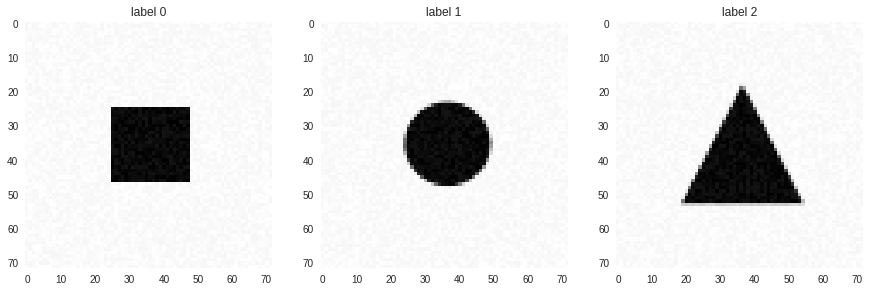

In [0]:

print(Y_train[:5])
size = X_train.shape[1]
print(X_train.shape)
X_0 = X_train[Y_train==0,:][0]
X_1 = X_train[Y_train==1,:][0]
X_2 = X_train[Y_train==2,:][0]
imgs_to_plot = [X_0, X_1, X_2]

plt.figure(figsize=(15,5))
for i in range(3):
    
    to_plot = imgs_to_plot[i].reshape((int(np.sqrt(size)),int(np.sqrt(size))))
    plt.subplot(1,3,i+1)
    plt.imshow(to_plot, cmap='Greys_r')
    plt.title('label ' + str(i))
    plt.grid(False)
    


### Classifier Model

We build a one layer neural network with a softmax acitvation function. Based on this model we try different optimizer : Stochastic Gradient Descent (SGD), ADAM, and customized SGD and ADAM.
The default SGD of Keras doesn't converge at all. But if we choose a lower learning rate it gives good results (accuracy = 0.9)
Adam gives always really good results
SGD with the appropriate learning rate gives good results.
Adam too but is easier to use

In [0]:
print("Training step with default SGD")
model = Sequential()
model.add(Dense(input_dim=X_train.shape[1], output_dim=3, activation="softmax"))


model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'],)

model.fit(X_train,Y, epochs=50,batch_size=32)


Training step with default SGD


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=5184, activation="softmax", units=3)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
3000/3000 [==============================] - 1s 419us/step - loss: 6.2744 - acc: 0.5320
Epoch 2/50
3000/3000 [==============================] - 0s 144us/step - loss: 5.5576 - acc: 0.6553
Epoch 3/50
3000/3000 [==============================] - 0s 138us/step - loss: 5.5532 - acc: 0.6560
Epoch 4/50
3000/3000 [==============================] - 0s 140us/step - loss: 5.5514 - acc: 0.6560
Epoch 5/50
3000/3000 [==============================] - 0s 147us/step - loss: 5.5499 - acc: 0.6560
Epoch 6/50
3000/3000 [==============================] - 0s 137us/step - loss: 5.5491 - acc: 0.6560
Epoch 7/50
3000/3000 [==============================] - 0s 148us/step - loss: 5.5484 - acc: 0.6560
Epoch 8/50
3000/3000 [==============================] - 0s 138us/step - loss: 5.5480 - acc: 0.6560
Epoch 9/50
3000/3000 [==============================] - 0s 142us/step - loss: 5.5477 - acc: 0.6560
Epoch 10/50
3000/3000 [==============================] - 0s 140us/step - loss: 5.5474 - acc: 0.6560
Epoch 11/

In [0]:
# Adam Optimizer 
print("Classification with default ADAM")
model = Sequential()
model.add(Dense(input_dim=X_train.shape[1], output_dim=3, activation="softmax"))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'],)

model.fit(X_train,Y, epochs=50,batch_size=32)


Classification with default ADAM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=5184, activation="softmax", units=3)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
3000/3000 [==============================] - 1s 204us/step - loss: 0.4962 - acc: 0.8243
Epoch 2/50
3000/3000 [==============================] - 0s 157us/step - loss: 0.1172 - acc: 0.9930
Epoch 3/50
3000/3000 [==============================] - 1s 253us/step - loss: 0.0557 - acc: 0.9993
Epoch 4/50
3000/3000 [==============================] - 0s 159us/step - loss: 0.0366 - acc: 0.9990
Epoch 5/50
3000/3000 [==============================] - 0s 161us/step - loss: 0.0255 - acc: 0.9997
Epoch 6/50
3000/3000 [==============================] - 0s 158us/step - loss: 0.0179 - acc: 0.9997
Epoch 7/50
3000/3000 [==============================] - 0s 164us/step - loss: 0.0148 - acc: 1.0000
Epoch 8/50
3000/3000 [==============================] - 0s 157us/step - loss: 0.0107 - acc: 1.0000
Epoch 9/50
3000/3000 [==============================] - 0s 161us/step - loss: 0.0090 - acc: 1.0000
Epoch 10/50
3000/3000 [==============================] - 0s 160us/step - loss: 0.0077 - acc: 0.9997
Epoch 11/

In [0]:
# Optilization with SGD small Learning Rate
print("Classification with customized SGD")
model = Sequential()
model.add(Dense(input_dim=X_train.shape[1], output_dim=3, activation="softmax"))

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'],)

model.fit(X_train,Y, epochs=50,batch_size=32)


Classification with customized SGD


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=5184, activation="softmax", units=3)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
3000/3000 [==============================] - 1s 191us/step - loss: 0.4821 - acc: 0.8153
Epoch 2/50
3000/3000 [==============================] - 0s 146us/step - loss: 0.1535 - acc: 0.9857
Epoch 3/50
3000/3000 [==============================] - 0s 146us/step - loss: 0.1031 - acc: 0.9910
Epoch 4/50
3000/3000 [==============================] - 0s 149us/step - loss: 0.0776 - acc: 0.9947
Epoch 5/50
3000/3000 [==============================] - 0s 148us/step - loss: 0.0611 - acc: 0.9973
Epoch 6/50
3000/3000 [==============================] - 0s 153us/step - loss: 0.0517 - acc: 0.9983
Epoch 7/50
3000/3000 [==============================] - 0s 147us/step - loss: 0.0436 - acc: 0.9987
Epoch 8/50
3000/3000 [==============================] - 0s 150us/step - loss: 0.0390 - acc: 0.9983
Epoch 9/50
3000/3000 [==============================] - 0s 147us/step - loss: 0.0343 - acc: 0.9987
Epoch 10/50
3000/3000 [==============================] - 0s 150us/step - loss: 0.0306 - acc: 0.9983
Epoch 11/

In [0]:
print("Classification with customized ADAM")
model = Sequential()
model.add(Dense(input_dim=X_train.shape[1], output_dim=3, activation="softmax"))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'],)

model.fit(X_train,Y, epochs=50,batch_size=32)



Classification with customized ADAM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=5184, activation="softmax", units=3)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/50
3000/3000 [==============================] - 1s 221us/step - loss: 0.4985 - acc: 0.7953
Epoch 2/50
3000/3000 [==============================] - 0s 162us/step - loss: 0.1276 - acc: 0.9860
Epoch 3/50
3000/3000 [==============================] - 0s 164us/step - loss: 0.0681 - acc: 0.9987
Epoch 4/50
3000/3000 [==============================] - 0s 157us/step - loss: 0.0398 - acc: 0.9993
Epoch 5/50
3000/3000 [==============================] - 0s 165us/step - loss: 0.0267 - acc: 0.9997
Epoch 6/50
3000/3000 [==============================] - 0s 158us/step - loss: 0.0200 - acc: 1.0000
Epoch 7/50
3000/3000 [==============================] - 0s 166us/step - loss: 0.0161 - acc: 0.9997
Epoch 8/50
3000/3000 [==============================] - 0s 160us/step - loss: 0.0127 - acc: 0.9997
Epoch 9/50
3000/3000 [==============================] - 0s 165us/step - loss: 0.0105 - acc: 0.9997
Epoch 10/50
3000/3000 [==============================] - 0s 159us/step - loss: 0.0090 - acc: 0.9997
Epoch 11/

## Visualization of the solution
By visualizing the wieghts we can see that some of them tries to match some of the shape that we want to recognize.

(5184, 3)


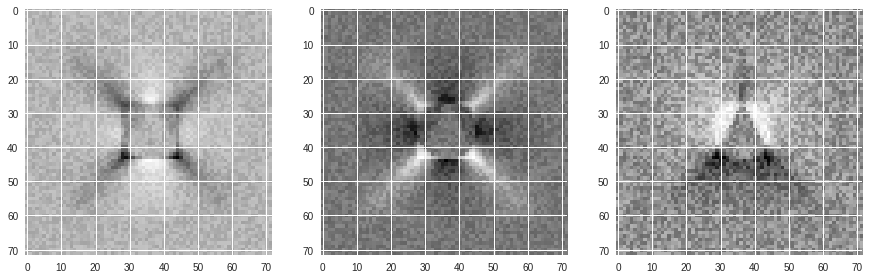

In [0]:
# display the weights as images
weights = model.get_weights()[0]
print(weights.shape)
row, col = weights.shape
plt.figure(figsize=(15,5))
for i in range(col):
    w = weights[:,i].reshape(int(np.sqrt(row)),int(np.sqrt(row)))
    plt.subplot(1,3,i+1)
    plt.imshow(w,cmap='Greys_r')
    

## A More Difficult Classification Problem

We want now to classify images with more intra-class variation. The geometrical figures are not centered anymore.
To do so, we will use a simple Convolutional Neural Network (CNN or ConvNet). But first let's see how the linear classifier perform

Creating data:
Creating data:
(3000, 72, 72, 1)
(3000, 3)


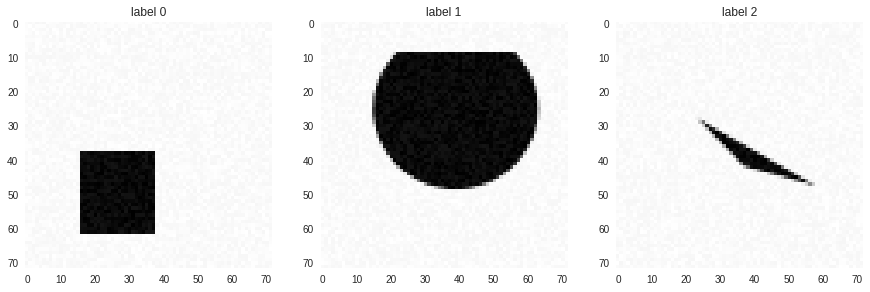

In [0]:
# generating data 

[X_train, Y_train] = generate_dataset_classification(n_train, 20, True)

[X_test, Y_test] = generate_test_set_classification()
Y = to_categorical(Y_train)

# visualize the data
size = X_train.shape[1]
X_0 = X_train[Y_train==0,:][0]
X_1 = X_train[Y_train==1,:][0]
X_2 = X_train[Y_train==2,:][0]
imgs = [X_0, X_1, X_2]

plt.figure(figsize=(15,5))
for i in range(3):
    
    img = imgs[i].reshape((int(np.sqrt(size)),int(np.sqrt(size))))
    plt.subplot(1,3,i+1)
    plt.imshow(img, cmap='Greys_r')
    plt.title('label ' + str(i))
    plt.grid(False)

#Resape the data    
size = int(np.sqrt(X_train.shape[1]))
X = X_train.reshape((n_train,size,size,1))

print(X.shape)
print(Y.shape)

### Linear Classifier

In [0]:
# linear classifier model

model = Sequential()
model.add(Dense(input_dim=X_train.shape[1], output_dim=3, activation="softmax"))


adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
fit_memory = model.fit(X_train, Y,epochs=200, batch_size=32, validation_data = [X_test,Y_test])



(3000, 5184)
(300, 5184)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=5184, activation="softmax", units=3)`
  after removing the cwd from sys.path.


Train on 3000 samples, validate on 300 samples
Epoch 1/200
3000/3000 [==============================] - 1s 245us/step - loss: 1.2021 - acc: 0.4673 - val_loss: 0.8709 - val_acc: 0.5000
Epoch 2/200
3000/3000 [==============================] - 1s 181us/step - loss: 0.9014 - acc: 0.5473 - val_loss: 0.9169 - val_acc: 0.5700
Epoch 3/200
3000/3000 [==============================] - 1s 175us/step - loss: 0.8882 - acc: 0.5633 - val_loss: 1.0885 - val_acc: 0.6000
Epoch 4/200
3000/3000 [==============================] - 1s 184us/step - loss: 0.9814 - acc: 0.5643 - val_loss: 0.8384 - val_acc: 0.6000
Epoch 5/200
3000/3000 [==============================] - 1s 178us/step - loss: 0.8261 - acc: 0.6090 - val_loss: 0.8630 - val_acc: 0.5900
Epoch 6/200
3000/3000 [==============================] - 1s 180us/step - loss: 0.8771 - acc: 0.5797 - val_loss: 0.7513 - val_acc: 0.5967
Epoch 7/200
3000/3000 [==============================] - 1s 174us/step - loss: 0.8642 - acc: 0.5817 - val_loss: 0.8216 - val_acc: 0

We can see that the accuracy on the training and test set s not very good. Also, one can notice that it's value oscillate with high amplitude. This can be explain by jumps during the backprogation step because of a to big learning rate.  Furthermore the loss are still decresing after 200 epochs.

300/300 [==============================] - 0s 90us/step


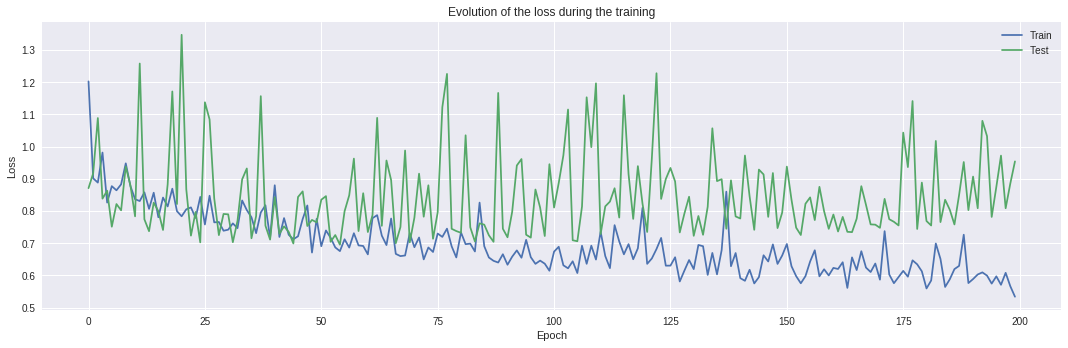

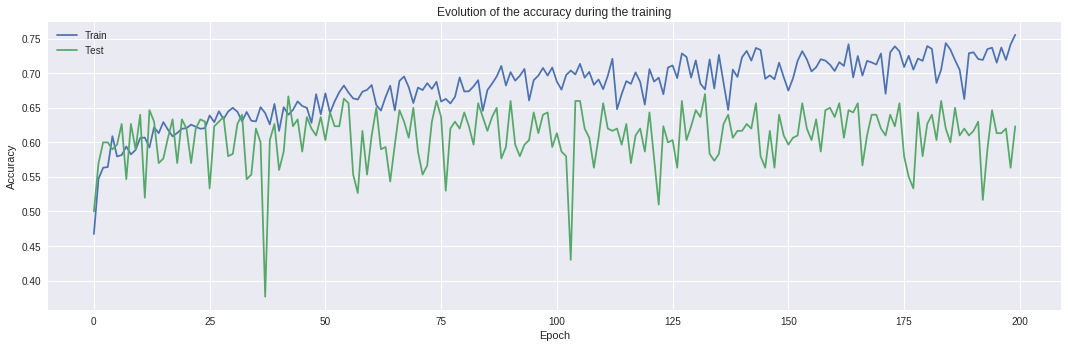

In [0]:
result = model.evaluate(X_test, Y_test)


#plot the loss curve
plt.figure(figsize=(15,5))
plt.plot(fit_memory.history['loss'], marker='', label="Train")
plt.plot(fit_memory.history['val_loss'], marker='', label="Test")
plt.xlabel(r'Epoch')
plt.ylabel(r'Loss')
plt.title(r'Evolution of the loss during the training')
plt.legend()
plt.tight_layout()
plt.show()

#plot the accuracy curve
plt.figure(figsize=(15,5))
plt.plot(fit_memory.history['acc'], marker='', label="Train")
plt.plot(fit_memory.history['val_acc'], marker='', label="Test")
plt.xlabel(r'Epoch')
plt.ylabel(r'Accuracy')
plt.title(r'Evolution of the accuracy during the training')
plt.legend()
plt.tight_layout()
plt.show()

To correct this we could use a smaller learning rate to move more smoothly on the loss function curve and see what happen.   I also increase the number of epochs to 500

In [0]:
# Linear classifier with a smaller learning rate (1e-4)
model = Sequential()
model.add(Dense(input_dim=X_train.shape[1], output_dim=3, activation="softmax"))


adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
fit_memory = model.fit(X_train, Y,epochs=500, batch_size=32, validation_data = [X_test,Y_test])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=5184, activation="softmax", units=3)`
  


Train on 3000 samples, validate on 300 samples
Epoch 1/500
3000/3000 [==============================] - 1s 202us/step - loss: 1.0876 - acc: 0.4033 - val_loss: 1.0221 - val_acc: 0.4433
Epoch 2/500
3000/3000 [==============================] - 0s 148us/step - loss: 0.9789 - acc: 0.5017 - val_loss: 0.9559 - val_acc: 0.5767
Epoch 3/500
3000/3000 [==============================] - 0s 157us/step - loss: 0.9172 - acc: 0.5520 - val_loss: 0.9111 - val_acc: 0.5933
Epoch 4/500
3000/3000 [==============================] - 0s 160us/step - loss: 0.8885 - acc: 0.5653 - val_loss: 0.8611 - val_acc: 0.6200
Epoch 5/500
3000/3000 [==============================] - 0s 167us/step - loss: 0.8627 - acc: 0.5797 - val_loss: 0.8829 - val_acc: 0.6067
Epoch 6/500
3000/3000 [==============================] - 0s 162us/step - loss: 0.8427 - acc: 0.5903 - val_loss: 0.8415 - val_acc: 0.6067
Epoch 7/500
3000/3000 [==============================] - 0s 166us/step - loss: 0.8296 - acc: 0.5953 - val_loss: 0.8137 - val_acc: 0

The model does not give better results and the test accuracy converge to 0.65. We could also play on the size of training set but in real life problems it's not possible. We usually augment the training set by transforming the data that we have.

300/300 [==============================] - 0s 99us/step


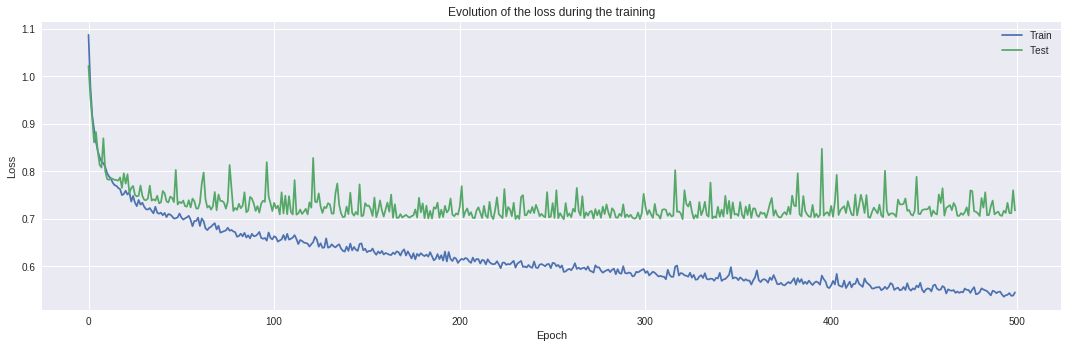

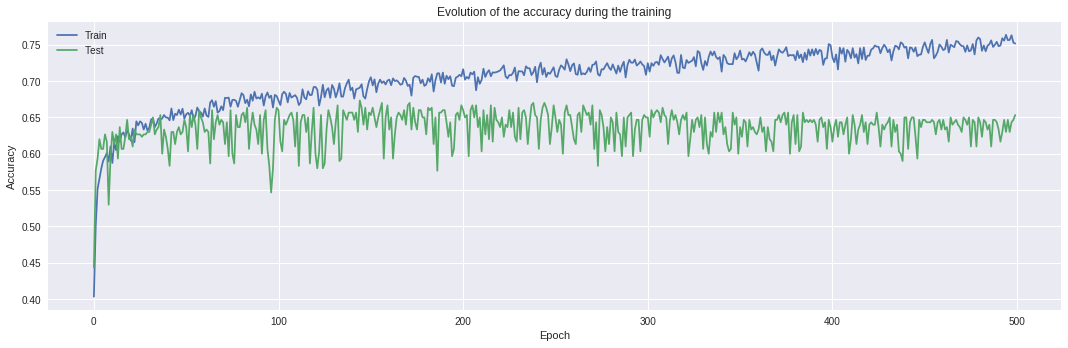

In [0]:
model.evaluate(X_test, Y_test)

#plot the loss curve
plt.figure(figsize=(15,5))

plt.plot(fit_memory.history['loss'], marker='', label="Train")
plt.plot(fit_memory.history['val_loss'], marker='', label="Test")
plt.xlabel(r'Epoch')
plt.ylabel(r'Loss')
plt.title(r'Evolution of the loss during the training')
plt.legend()
plt.tight_layout()
plt.show()

#plot the accuracy curve
plt.figure(figsize=(15,5))
plt.plot(fit_memory.history['acc'], marker='', label="Train")
plt.plot(fit_memory.history['val_acc'], marker='', label="Test")
plt.xlabel(r'Epoch')
plt.ylabel(r'Accuracy')
plt.title(r'Evolution of the accuracy during the training')
plt.legend()
plt.tight_layout()
plt.show()


### Convolutional Neural Network

Let's now consider a simple ConvNet with one Convolutional layer and one fully connected layer.

In [0]:
# Convnet model for classification

convnet = Sequential()
convnet.add(Conv2D(16, kernel_size=5,activation='relu',input_shape=(size,size,1)))
convnet.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
convnet.add(Flatten())
print(convnet.output_shape)
convnet.add(Dense(3,activation='softmax'))
convnet.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

n_test = X_test.shape[0] 
size = int(np.sqrt(X_test.shape[1]))
X_test = X_test.reshape((n_test,size,size,1))
fit_memory = convnet.fit(X, Y,epochs=200, batch_size=32, validation_data = [X_test,Y_test])


(None, 18496)
Train on 3000 samples, validate on 300 samples
Epoch 1/200
3000/3000 [==============================] - 2s 658us/step - loss: 0.8296 - acc: 0.6403 - val_loss: 0.5897 - val_acc: 0.7933
Epoch 2/200
3000/3000 [==============================] - 1s 305us/step - loss: 0.4710 - acc: 0.8173 - val_loss: 0.4212 - val_acc: 0.8433
Epoch 3/200
3000/3000 [==============================] - 1s 306us/step - loss: 0.3702 - acc: 0.8710 - val_loss: 0.3345 - val_acc: 0.8667
Epoch 4/200
3000/3000 [==============================] - 1s 300us/step - loss: 0.2739 - acc: 0.9060 - val_loss: 0.2809 - val_acc: 0.8833
Epoch 5/200
3000/3000 [==============================] - 1s 301us/step - loss: 0.2207 - acc: 0.9220 - val_loss: 0.2367 - val_acc: 0.9067
Epoch 6/200
3000/3000 [==============================] - 1s 302us/step - loss: 0.1897 - acc: 0.9363 - val_loss: 0.2263 - val_acc: 0.9100
Epoch 7/200
3000/3000 [==============================] - 1s 302us/step - loss: 0.1741 - acc: 0.9460 - val_loss: 0.236

The ConvNet give impressive results compared to the previous model. Even when the network seems to overfit, it does not play a big role on the test set accuracy. We could Have stoped at 20 epochs. This model could be improved by stacking one or two other convolutionnal layer. But adding more parameters too learn could also lead to more overfitting. It's a trade-off that should be considered when it comes to design a CNN.

300/300 [==============================] - 0s 147us/step


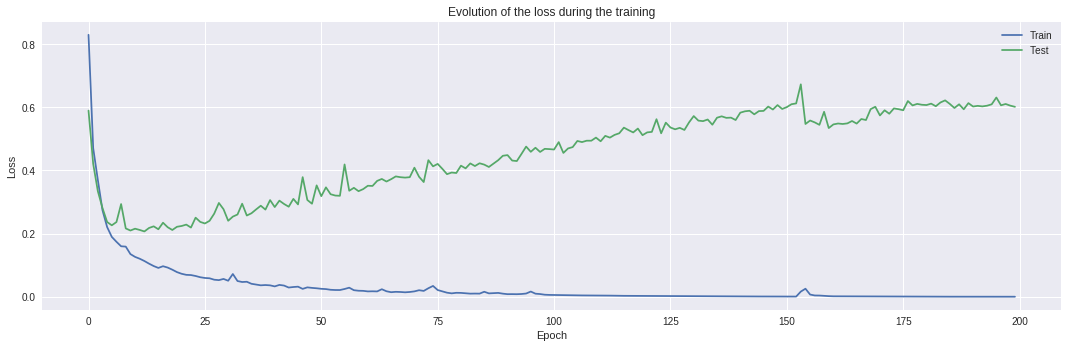

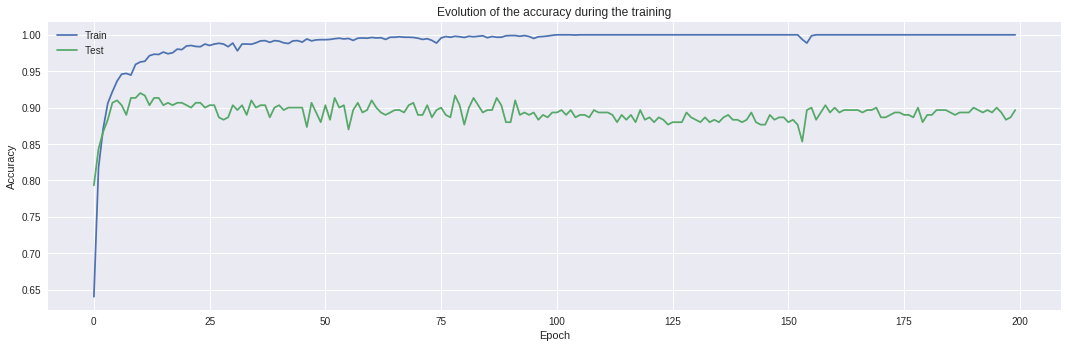

In [0]:
#Plot the loss curve

convnet.evaluate(X_test, Y_test)

plt.figure(figsize=(15,5))

plt.plot(fit_memory.history['loss'], marker='', label="Train")
plt.plot(fit_memory.history['val_loss'], marker='', label="Test")
plt.xlabel(r'Epoch')
plt.ylabel(r'Loss')
plt.title(r'Evolution of the loss during the training')
plt.legend()
plt.tight_layout()
plt.show()

# plot the accuracy curve
plt.figure(figsize=(15,5))
plt.plot(fit_memory.history['acc'], marker='', label="Train")
plt.plot(fit_memory.history['val_acc'], marker='', label="Test")
plt.xlabel(r'Epoch')
plt.ylabel(r'Accuracy')
plt.title(r'Evolution of the accuracy during the training')
plt.legend()
plt.tight_layout()
plt.show()

## A Regression Problem 
The objectif is now to estimate the position of the vertices of a triangle on a image. 
After a quick over view on the outputs generated, we see that they're is no real logic in the order of the vertices. As discussed with other students, I decided to order those vertices according to the x-axis (which improves the results).
Since this is a regression problem, the loss function that we want to minimise is the mean square error.

In [0]:
# Generating data

[X_train, Y_train] = generate_dataset_regression(n_train, 20)
[X_test, Y_test] = generate_test_set_regression()


Creating data:
Creating data:


In [0]:
# visualize the data
print(X_train[:10].shape)
#visualize_prediction(X_train[0].reshape(1,-1), Y_train[0],1,1)

# reshape the images
size = int(np.sqrt(X_train.shape[1]))
X = X_train.reshape((n_train,size,size,1))
X_test = X_test.reshape((n_test,size,size,1))

(10, 5184)


In [0]:
# function to order coordinate according to x axis 

def ordered_coord(Y):
    n_sample, n_output = Y.shape
    for i in range(n_sample):
        x_1,x_2,x_3 = Y[i,0], Y[i,2], Y[i,4]
        if x_1 == np.max((x_1,x_2,x_3)):
            if x_2 == np.min((x_1,x_2,x_3)):
                Y[i,:] = np.array([Y[i,0], Y[i,1], Y[i,4], Y[i,5], Y[i,2], Y[i,3]])
            else :
                Y[i,:] = np.array([Y[i,0], Y[i,1], Y[i,2], Y[i,3], Y[i,4], Y[i,5]])
        if x_2 == np.max((x_1,x_2,x_3)):
            if x_1 == np.min((x_1,x_2,x_3)):
                Y[i,:] = np.array([Y[i,2], Y[i,3], Y[i,4], Y[i,5], Y[i,0], Y[i,1]])
            else :
                Y[i,:] = np.array([Y[i,2], Y[i,3], Y[i,0], Y[i,1], Y[i,4], Y[i,5]])
        if x_3 == np.max((x_1,x_2,x_3)):
            if x_1 == np.min((x_1,x_2,x_3)):
                Y[i,:] = np.array([Y[i,4], Y[i,5], Y[i,2], Y[i,3], Y[i,0], Y[i,1]])
            else :
                Y[i,:] = np.array([Y[i,4], Y[i,5], Y[i,0], Y[i,1], Y[i,2], Y[i,3]])
    return Y
Y_test = ordered_coord(Y_test)

### ConvNet for Regression Problem

In [0]:
# Model for the regression problem
convnet2 = Sequential()
convnet2.add(Conv2D(16, kernel_size=5,activation='relu',input_shape=(size,size,1)))
convnet2.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
convnet2.add(Conv2D(64, kernel_size=3,activation='relu',input_shape=(size,size,1)))
convnet2.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
convnet2.add(Conv2D(128, kernel_size=3,activation='relu',input_shape=(size,size,1)))
convnet2.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
convnet2.add(Flatten())
print(convnet.output_shape)
convnet2.add(Dense(6))
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
convnet2.compile(optimizer=adam, loss='mean_squared_error', metrics=['mse'])

Y_train = ordered_coord(Y_train)
Y_test_reg = ordered_coord(Y_test)
fit_memory = convnet2.fit(X, Y_train,epochs=300, batch_size=10,validation_data = [X_test,Y_test])

(None, 3)
Train on 3000 samples, validate on 300 samples
Epoch 1/300
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 2/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.0259 - val_mean_squared_error: 0.0259
Epoch 3/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 4/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0188 - val_mean_squared_error: 0.0188
Epoch 5/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 6/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val

300/300 [==============================] - 0s 309us/step


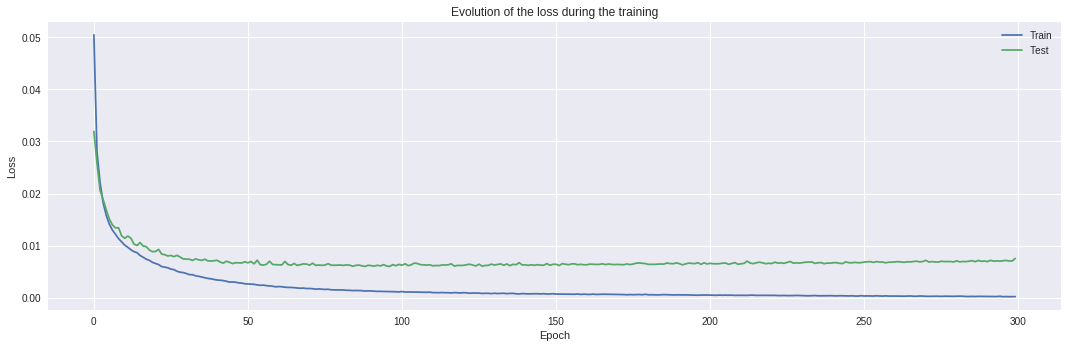

In [0]:
# Plot the loss curve
convnet2.evaluate(X_test, Y_test)

plt.figure(figsize=(15,5))

plt.plot(fit_memory.history['loss'], marker='', label="Train")
plt.plot(fit_memory.history['val_loss'], marker='', label="Test")
plt.xlabel(r'Epoch')
plt.ylabel(r'Loss')
plt.title(r'Evolution of the loss during the training')
plt.legend()
plt.tight_layout()
plt.show()


### Results

The results seems correct with a mean square error of 0.007.  Regression is a tougher problem since we want to get results on a continuous set of values.But when the triangle is not too squeezed/flattened, the network gives a good approximation on the position of the vertices. One could add dropout layers to try to improve the results.  

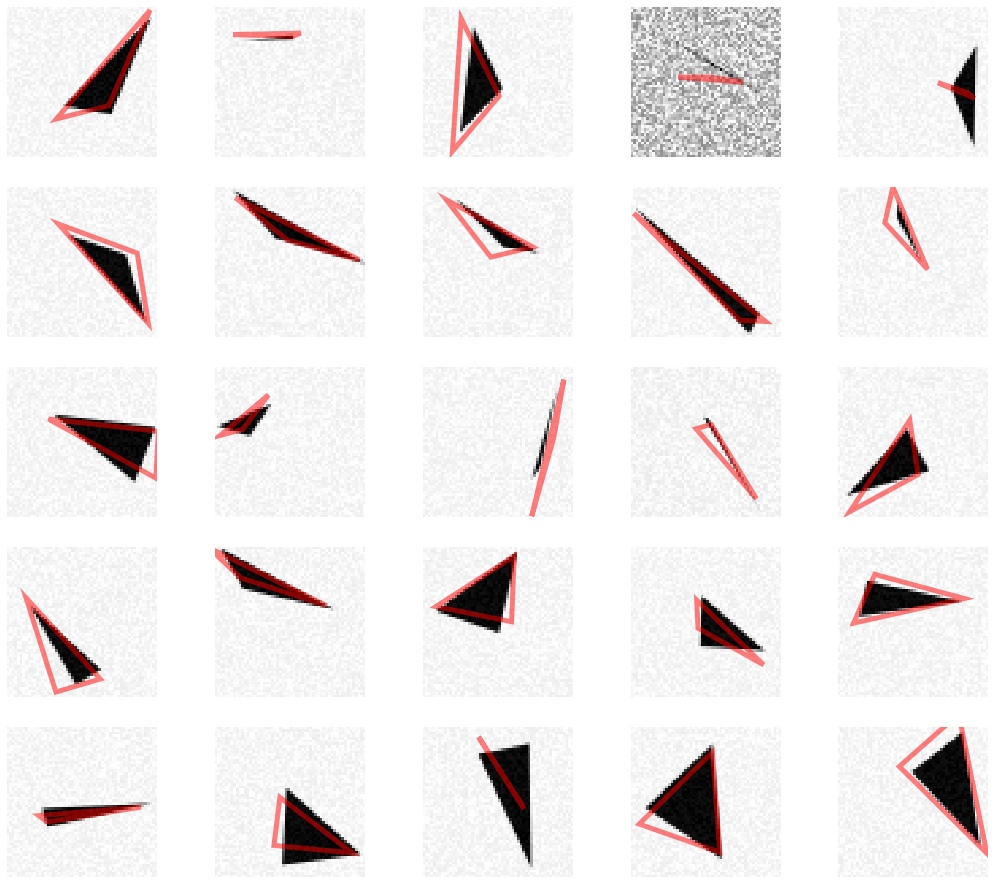

In [0]:
# Visualize the results
y_test_pred = convnet2.predict(X_test)

visualize_prediction(X_test[:25],y_test_pred[:25], 5,5)    


##  Denoising

We now want to denoise the images. This time the network will have to return an image. 
Since the denoised image is binary, we can also see this problem as an image segmentation with two segments to found.
The segmentation problem can also be seen as a pixel-wise classification.

The CNN architecture considered for this problem is the hourglass network, or encoder-decoder, which will try to learn a representation of the images and reconstruct them. We will consider the classical mean square error loss and then the binary cross-entropy.

Creating data:
Creating data:
(3000, 5184)


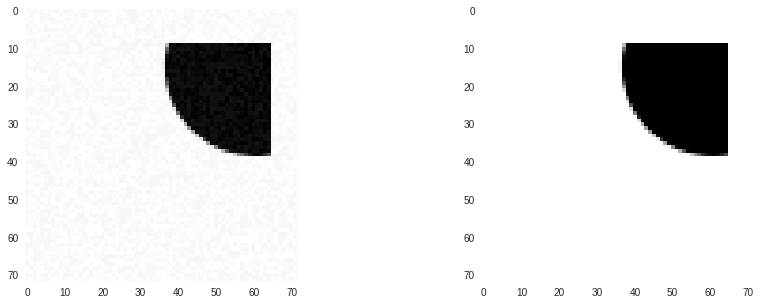

In [5]:
# Visualize the data

[X_image, Y_image] = generate_dataset_denoising(n_train, noise=20, free_location=True)
[X_test, Y_test] = generate_testset_denoising()
print(X_image.shape)
size = int(np.sqrt(X_image.shape[1]))
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(X_image[0,:].reshape((size,size)), cmap="Greys_r")
plt.grid(False)
plt.subplot(122)
plt.imshow(Y_image[0,:].reshape((size,size)), cmap="Greys_r")
plt.grid(False)


# Generate rehape the data
n_sample, n_px = X_image.shape
size = int(np.sqrt(n_px))
X_train = X_image.reshape((n_sample,size,size,1))
Y_train = Y_image.reshape((n_sample,size,size,1))
n_test = Y_test.shape[0]
X_test = X_test.reshape((n_test,size,size,1))
Y_test = Y_test.reshape((n_test,size,size,1))

In [0]:
# function to visualize the result of the denoising 
def visualise_denoising(x, y, nr):
    fig, axarr = plt.subplots(figsize=(18, 16),nrows=nr,ncols=4)
    
    index=0
    for i in range(nr):
        axarr[i,0].imshow(x[index], cmap='Greys_r')
        axarr[i,0].grid(False)
        axarr[i,1].imshow(y[index], cmap='Greys_r')
        axarr[i,1].grid(False)
        index+=1
        axarr[i,2].imshow(x[index], cmap='Greys_r')
        axarr[i,2].grid(False)
        axarr[i,3].imshow(y[index], cmap='Greys_r')
        axarr[i,3].grid(False)
        index+=1
    plt.show()

### U-ConvNet with mean square error loss



In [14]:


# First model for the denoising problem
denoise1 = Sequential()
denoise1.add(Conv2D(16, kernel_size=3,activation='relu',input_shape=(size,size,1), padding='same'))
denoise1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
denoise1.add(Conv2D(64, kernel_size=3,activation='relu', padding='same'))
denoise1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
denoise1.add(Conv2D(128, kernel_size=3,activation='relu', padding='same'))
denoise1.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
denoise1.add(Conv2D(128, kernel_size=3,activation='relu', padding='same'))
denoise1.add(UpSampling2D((2,2)))
denoise1.add(Conv2D(64, kernel_size=3,activation='relu', padding='same'))
denoise1.add(UpSampling2D((2,2)))
denoise1.add(Conv2D(16, kernel_size=3,activation='relu', padding='same'))
denoise1.add(UpSampling2D((2,2)))
denoise1.add(Conv2D(1, kernel_size=3,activation='relu', padding='same'))

#denoise.summary()

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
denoise1.compile(optimizer=adam, loss='mean_squared_error')
denoise1.fit(X_train, Y_train,epochs=300, batch_size=32,validation_data = [X_test,Y_test])



Train on 3000 samples, validate on 300 samples
Epoch 1/300
3000/3000 [==============================] - 4s 1ms/step - loss: 0.1355 - val_loss: 0.0211
Epoch 2/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0145 - val_loss: 0.0120
Epoch 3/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0100 - val_loss: 0.0091
Epoch 4/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0078 - val_loss: 0.0073
Epoch 5/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 6/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0055 - val_loss: 0.0052
Epoch 7/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 8/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 9/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 10/300
3000/3000 [==

Since the network returns a non binary value, we threshold the output value to only get 2 values for the pixels (0 or 1).
The model seems to give good results but it struggle when it commes to small figures or when the Signal to Noise Ration (SNR) is too small.

[0.         0.00784314 0.03137255 0.04705882 0.09019608 0.09411765
 0.10196078 0.10588235 0.10980392 0.11372549 0.11764706 0.1254902
 0.12941176 0.1372549  0.14509804 0.18823529 0.21176471 0.2745098
 0.30196078 0.3372549  0.42352941 0.42745098 0.47843137 0.54509804
 0.54901961 0.55686275 0.56470588 0.57254902 0.58039216 0.58431373
 0.58823529 0.59607843 0.6        0.60784314 0.61568627 0.62352941
 0.63137255 0.65490196 0.70980392 0.7372549  0.75294118 0.81568627
 0.83921569 0.85882353 0.86666667 0.9372549  0.95686275 0.96078431
 0.96470588 0.96862745 0.97254902 0.97647059 0.98039216 0.98431373
 0.98823529 0.99215686 1.        ]


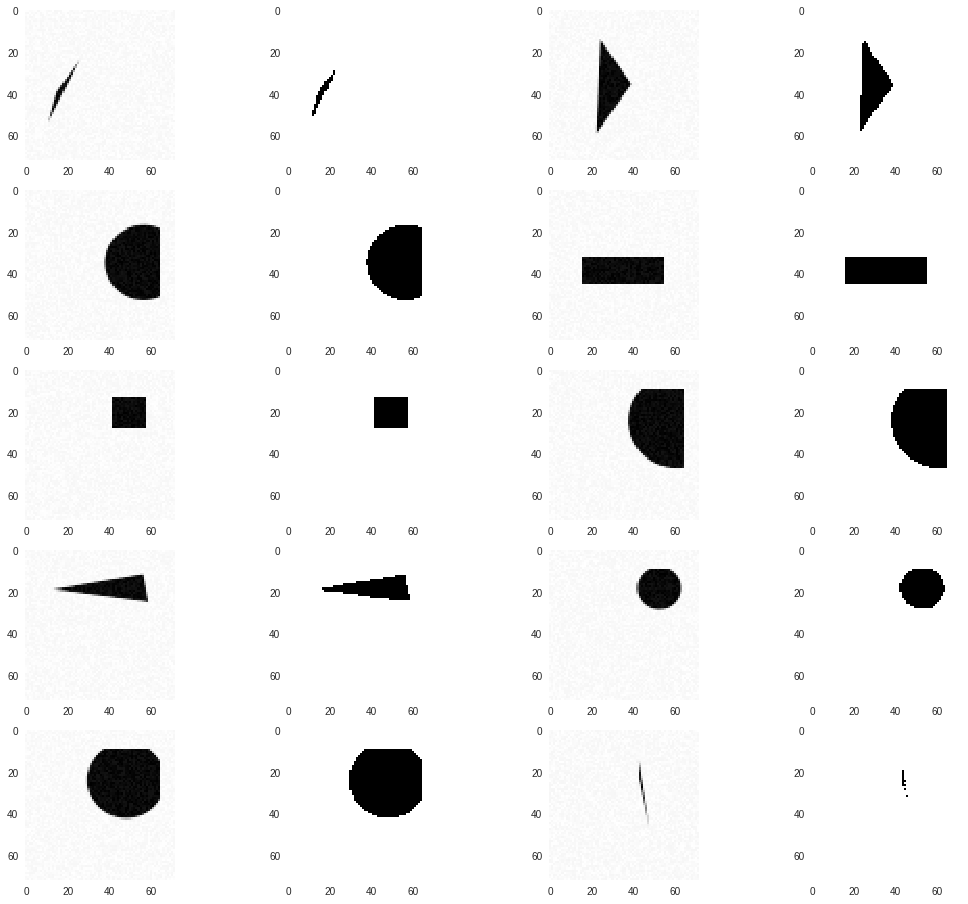

In [15]:
# Visulaize the results
Y_pred = denoise1.predict(X_test)
print(np.unique(Y_test[0]))
visualise_denoising(np.squeeze(X_test),np.squeeze(Y_pred)>0.5,5)

### U-Net with binary cross entropy

I used the same network as before and only used a sigmoid in the last layer.

In [16]:
# Second model for the denoising problem
denoise2 = Sequential()
denoise2.add(Conv2D(16, kernel_size=3,activation='relu',input_shape=(size,size,1), padding='same'))
denoise2.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
denoise2.add(Conv2D(64, kernel_size=3,activation='relu', padding='same'))
denoise2.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
denoise2.add(Conv2D(128, kernel_size=3,activation='relu', padding='same'))
denoise2.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
denoise2.add(Conv2D(128, kernel_size=3,activation='relu', padding='same'))
denoise2.add(UpSampling2D((2,2)))
denoise2.add(Conv2D(64, kernel_size=3,activation='relu', padding='same'))
denoise2.add(UpSampling2D((2,2)))
denoise2.add(Conv2D(16, kernel_size=3,activation='relu', padding='same'))
denoise2.add(UpSampling2D((2,2)))
denoise2.add(Conv2D(1, kernel_size=3,activation='sigmoid', padding='same'))

#denoise.summary()

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
denoise2.compile(optimizer=adam, loss='binary_crossentropy')
denoise2.fit(X_train, Y_train,epochs=300, batch_size=32,validation_data = [X_test,Y_test])


Train on 3000 samples, validate on 300 samples
Epoch 1/300
3000/3000 [==============================] - 4s 1ms/step - loss: 0.3039 - val_loss: 0.0680
Epoch 2/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0458 - val_loss: 0.0389
Epoch 3/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0355 - val_loss: 0.0320
Epoch 4/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0290 - val_loss: 0.0265
Epoch 5/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0241 - val_loss: 0.0224
Epoch 6/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0207 - val_loss: 0.0192
Epoch 7/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0185 - val_loss: 0.0175
Epoch 8/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0169 - val_loss: 0.0162
Epoch 9/300
3000/3000 [==============================] - 3s 1ms/step - loss: 0.0157 - val_loss: 0.0160
Epoch 10/300
3000/3000 [==

The results are better than for the previons model. The shape of the figures are kept and it perform better on low SNR images. 

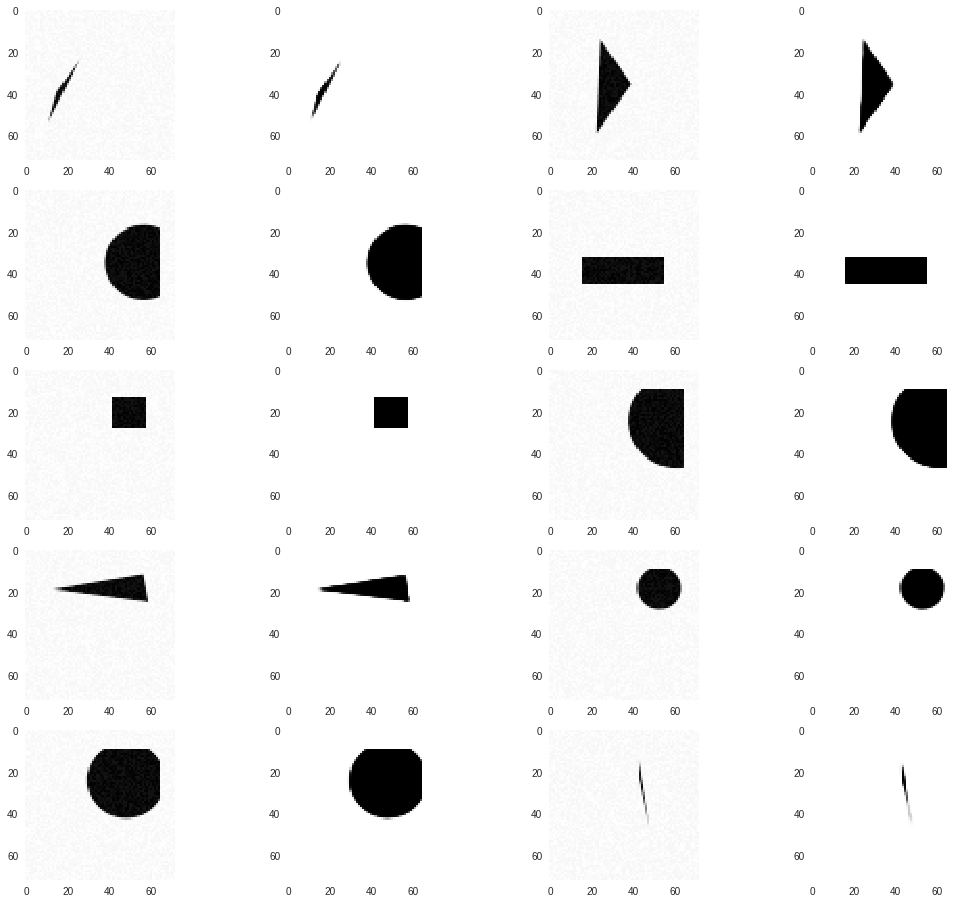

In [17]:
# Visualize the results

Y_pred = denoise2.predict(X_test)
visualise_denoising(np.squeeze(X_test),np.squeeze(Y_pred),5)


### Denoising with Skip Layers
Now we will try U-net with skip layers . It seems that it performrs even better than the two previous models.

In [12]:

input_l = Input((size,size,1))
conv1 = Conv2D(16, kernel_size=3,activation='relu',input_shape=(size,size,1), padding='same')(input_l)
max1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(conv1)
conv2 = Conv2D(64, kernel_size=3,activation='relu', padding='same')(max1)
max2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(conv2)
conv3 = Conv2D(128, kernel_size=3,activation='relu', padding='same')(max2)
max3 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(conv3)
conv4 = Conv2D(128, kernel_size=3,activation='relu', padding='same')(max3)
up1 = UpSampling2D((2,2))(conv4)
merge1 = concatenate([conv3,up1], axis=3)
conv5 = Conv2D(64, kernel_size=3,activation='relu', padding='same')(merge1)
up2 = UpSampling2D((2,2))(conv5)
merge2 = concatenate([conv2,up2], axis=3)
conv6 = Conv2D(16, kernel_size=3,activation='relu', padding='same')(merge2)
up3 = UpSampling2D((2,2))(conv6)
merge3 = concatenate([conv1,up3], axis=3)
conv7 = Conv2D(1, kernel_size=3,activation='sigmoid', padding='same')(merge3)

adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
denoise3 = Model(input=input_l, output=conv7)
denoise3.compile(optimizer=adam, loss='binary_crossentropy')
denoise3.fit(X_train, Y_train,epochs=300, batch_size=32,validation_data = [X_test,Y_test])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Train on 3000 samples, validate on 300 samples
Epoch 1/300
3000/3000 [==============================] - 8s 3ms/step - loss: 0.1989 - val_loss: 0.0358
Epoch 2/300
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0289 - val_loss: 0.0254
Epoch 3/300
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0224 - val_loss: 0.0207
Epoch 4/300
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0183 - val_loss: 0.0186
Epoch 5/300
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0158 - val_loss: 0.0147
Epoch 6/300
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0141 - val_loss: 0.0135
Epoch 7/300
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0127 - val_loss: 0.0120
Epoch 8/300
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0116 - val_loss: 0.0111
Epoch 9/300
3000/3000 [==============================] - 4s 1ms/step - loss: 0.0108 - val_loss: 0.0105
Epoch 10/300
3000/3000 [==

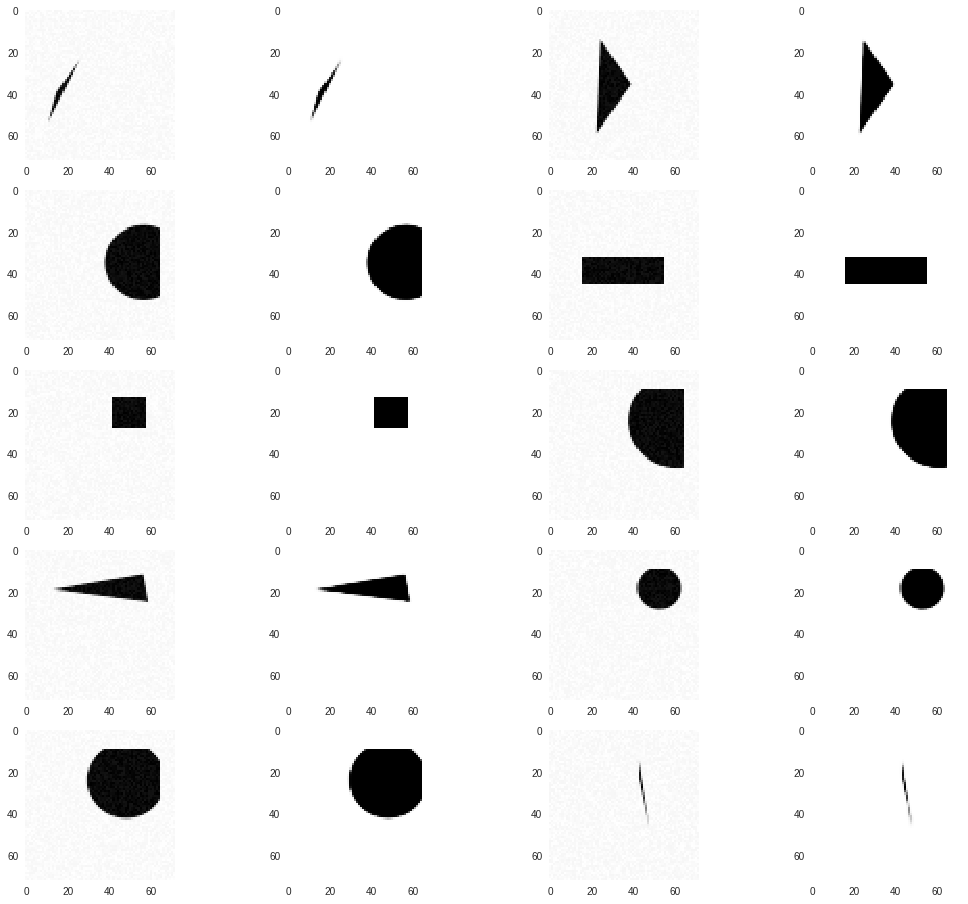

In [13]:
Y_pred = denoise3.predict(X_test)
visualise_denoising(np.squeeze(X_test),np.squeeze(Y_pred),5)